# XGBoost in a Nutshell

_Author_: QH  
_First Version Date: 2022-11-18_  
_Latest update on: 2022-11-18_

## 1. XGBoost vs. Gradient Boosting Machine (GBM)
The full name for XGBoost is "Extreme Gradient Boosting which is a specific implementation of the Gradient Boosting method using accurate approximations to find the best tree model. Specifically,

1. XGBoost takes the *Taylor expansion* of the loss function up to the second order (i.e. second partial derivatives of the loss function). It simplifies the cost function and thus easy to compute.
2. XGBoost has advanced regularization (L1 & L2), which improves model generalization.
3. Training using XGBoost is very fast and can be parallelized / distributed across clusters.

Quote from XGBoost Author Tianqi Chen:

> *Both xgboost and gbm follow the principle of gradient boosting. There are however, the difference in modeling details. Specifically, xgboost used a more regularized model formalization to control over-fitting, which gives it better performance.*

> *The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. For model, it might be more suitable to be called as regularized gradient boosting.*

## 2. Mathematical setup for Supervising Learning

1. **Model**  
A mathmatical structure or mapping to generate a prediction or estimate for $y_i$ from input $x_i$, where $i$ is the $i^{th}$ observation. Several examples as follows:
  + Linear Regression Model: $\hat{y}_i = \sum_j\theta_j x_{ij}$, where $j$ means the $j^{th}$ coefficient and $i$ is the $i^{th}$ observation.
  + Generalized Linear Model or GLM (Logistic Regression is one of them): $\hat{y}_i = g^{-1}\left(\sum_j\theta_j x_{ij}\right)$, where $g$ is the link function. Specifically, for logistic regression $g\left(\mu \right) = \log \left( \frac{\mu}{1-\mu} \right)$ and $g^{-1}\left(\mu \right)  = \frac{1}{1 + \exp^{-\mu}}$. For more information on GLM, please refer to notebook <mark> GLM_Methodology_Application.ipynb </mark>.
  
2. **Parameters**  
Parameters are the part in the **Model** that needs to be determined in order to perform the prediction. In the Linear Regression Model and GLM case, $\theta$ is the set of parameters that needs to be "learnt" from the data. 

3. **Model Training**  
The process to find the **best** parameters $\theta$ that fit the training data $X$ and the target variable $y$.

4. **Objective Function**  
The next natural questions is: How do we find the **best** parameter? We need to define the **objective function** for the parameters to best fit for the training data. The generic term for the objective function is as follows:  
$$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$$ 
How to interpret the above function? There are two components which are illustrated as follows:
 + **Training Loss**  
 $L\left( \cdot \right) $ is the training loss function. It measures how good or accurate prediction does the model have for the training data. Several examples as follows:
     * The most commonly used one is the *mean squared error(MSE)* given by: $L(\theta) = \sum_i (y_i-\hat{y}_i)^2$.
     * Another commonly used loss is the *logistic loss* given by:
     $L(\theta) = \sum_i\left[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})\right]$.
 
 + **Regularization Term**   
 $\Omega \left( \cdot \right)$ is the regularization term. It is a control from having a too complicated model and helps to avoid overfitting. This is generated from the principle to have a *parsimonious model*.  Parsimonious Models are simple models with great explanatory predictive power. They explain data with a minimum number of parameters, or predictor variables. Generally speaking, we need to develop a model that is a balance between *bias* and *variance*. For more illustration on **bias and variance tradeoff**, please refer to the notebook <mark> Bias_Variance_Tradeoff.ipynb</mark>.

## 3. Ensemble Tree Method

### 3.1 Decision Trees
For more information on the decision trees refer to another notebook: *<mark>Tree_Based_Methods.ipynb</mark>*.  
### 3.2 Classification and Regression trees (CART)
In CART, a real score is associated with each of the leaves, which gives us richer interpretations that allows for a principled, unified approach to optimization.

### 3.3 Ensemble Methods
Normally a single CART estimation is not accurate enough. Practically, different CARTs are integrated to generate the final prediction, e.g sum of different tree predictions as follows,
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$
where $K$ is the total number of trees, $f_k\left( \cdot \right)$ is a function in the function space $\mathcal{F}$ and $\mathcal{F}$ is the set of all CARTs.  
And the objection function is defined as follows:
$$\text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

### 3.4 Boosting and Additive Training
Learning tree structure is much harder than traditional optimization problem where you can simply take the gradient. It is intractable to learn all the trees at once. Instead, we can use an additive strategy: fix what we have learned, and add one new tree at a time. Let's rewrite the prediction and objection step by step:  
For prediction:
$$\begin{split}
\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}$$
For Objection function at step $t$:
$$\begin{split}
\text{obj}^{(t)} &= \sum_i^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t \Omega(f_i)\\
                         &= \sum_i^n l \left( y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{Constant}
\end{split}$$

## 4. What are the specifics for XGBoost?

### 4.1 Taylor Expansion
As you can imagine the if the loss function is simple (meaning only with first order and quadratic terms like *MSE*), the optimization of the objective function is easier to solve. This generates the idea in XGBoost to use *Taylor Expansion of the loss function up to the second order* at $\hat{y}_i^{(t-1)}$:
$$\begin{split}
\text{obj}^{(t)} &= \sum_i^n l \left( y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{Constant}\\
&= \sum_{i=1}^n \left[ l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)\right] + \Omega(f_t) + \mathrm{Constant}
\end{split}$$
where $g_i$ and $h_i$ are the first order and second order derivatives of $l(\cdot)$ at $\hat{y}_i^{(t-1)}$, specifically:
$$\begin{split}
g_i &= \partial_{\hat{y}_i^{(t-1)}} l\left(y_i, \hat{y}_i^{(t-1)}\right)\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l\left(\hat{y}_i^{(t-1)}\right)
\end{split}$$
Don't forget the target of the optimization: we need to find the best $f_t(\cdot)$ that minimize the $obj^{(t)}$ and thus we can even simplify the objective function by removing the constants:
$$\sum_{i=1}^n \left[g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)\right] + \Omega(f_t)$$
As you can see from the above equation, the advantage is the value of the objective function only depends on $g_i$ and $h_i$. **In this sense, XGBoost can support customized loss functions as long as the first and second order derivative forms are provided!**  

### 4.2 Regularization
What about the regularization term $\Omega(f_t)$? XGBoost redefines the tree $f_t(x)$ as:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} $$
Here $w$ is the vector of scores on leaves, $q$ is a function assigning each data point to the corresponding leaf, and $T$ is the number of leaves.  
XGBoost defines the complexity or the regularization term as follows according to the re-written tree definition:
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$$
where $w_j$ is the score for the $j^{th}$ leaf in the tree.  
**Compared with other packages treating regularization less carefully, XGBoost defines the regularization term formmaly which can rigorously reduce the overfitting problem!**

### 4.3 The new objective function and solution! 
After re-formulating the tree model, we can write the objective value with the $t^{th}$ tree as:
$$\begin{split}
\text{obj}^{(t)} &\approx \sum_{i=1}^n \left[g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2 \right] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
&= \sum^T_{j=1} \left[\left(\sum_{i\in I_j} g_i\right) w_j + \frac{1}{2} \left(\sum_{i\in I_j} h_i + \lambda \right) w_j^2 \right] + \gamma T
\end{split}$$  
where $I_j = \{i|q(x_i)=j\}$ is the set of indices of data points assigned to the $j^{th}$ leaf.  

Notice that in the second line we have changed the index of the summation because all the data points on the same leaf get the same score.  

We could further compress the expression by defining $G_j = \sum_{i\in I_j} g_i$ and $H_j = \sum_{i\in I_j} h_i$ as follows:  
$$ \text{obj}^{(t)} = \sum^T_{j=1} \left[G_jw_j + \frac{1}{2} \left(H_j+\lambda \right) w_j^2 \right] +\gamma T\$$

In this equation, $w_j$ is independent with respect to each other, the form $G_jw_j+\frac{1}{2}\left(H_j+\lambda\right)w_j^2$ is quadratic and the best $w_j$ for a given structure $q(x)$ and the best objective reduction we can get is
$$
\begin{split}w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T
\end{split}$$
The last equation measures *how good* a tree structure $q(x)$ is.  

#### 4.3.1 Mean Squared Error as the loss function
Let's use mean squared error as the loss function, i.e.  $l\left(y_i, \hat{y}_i^{(t-1)}\right) = \left(y_i-\hat{y}_i^{(t-1)}\right)^2$. Then it is easy to calculate $g_i = -2 \cdot \left(y_i-\hat{y}_i^{(t-1)}\right) $ and $h_i = 2$. So the objective function is:
$$\text{obj}^\ast = - \sum_{j=1}^T \frac{\left(\sum_{i\in I_j} \left(y_i-\hat{y}_i^{(t-1)}\right)\right)^2}{\sum_{i\in I_j}+\lambda/2} + \gamma T$$ 
and 
$$w_j^\ast = \frac{\sum_{i\in I_j} \left(y_i-\hat{y}_i^{(t-1)}\right)}{\sum_{i\in I_j}+\lambda/2}$$ 
For example, if there are in total 4 observations. For the root of the tree: $\text{obj}_{T = 1} ^\ast = - \frac{\left(\sum_{i = 1}^{ 4} \left(y_i-\hat{y}_i^{0}\right) \right)^2} {4 +\lambda/2} + \gamma$.
#### 4.3.2 Logistic loss
Let's use logistic loss as the loss function, i.e. $l\left( y_i, p_i \right) = -\left(y_i \log{p_i} + \left( 1 - y_i \right) \log{\left(1 - p_i\right)} \right) = -y_i \log{\frac{p_i}{1 - p_i}} + \log{\left(1 + \frac{p_i}{1 - p_i} \right)}$. Let <mark> $z_i = \text{logodds} = \log{\frac{p_i}{1 - p_i}}$, then $l\left(y_i, z_i\right) = -y_i z_i + \log{\left( 1 + e^{z_i}\right)}$ </mark>. Then we can get both first and second order derivatives:
$$\partial_{z_i}{l_i} = g_i = -y_i + \frac{e^{g_i}}{1 + e^{g_i}} = p_i - y_i$$
$$\partial_{z_i}^2 l_i = h_i = \frac{e^{g_i}}{\left(1 + e^{g_i}\right)^2} = p_i(1-p_i)$$
With the objective function and optimal scores on each node becomes:
$$\text{obj}^\ast = - \sum_{j=1}^T \frac{\left(\sum_{i\in I_j} \left(y_i-p_i^{(t-1)}\right)\right)^2}{\sum_{i\in I_j}\left[p_i^{(t-1)} \left(1-p_i^{(t-1)}\right)\right] +\lambda/2} + \gamma T$$
$$w_j^\ast = \frac{\sum_{i\in I_j} \left(y_i-p_i^{(t-1)}\right)}{\sum_{i\in I_j}\left[p_i^{(t-1)} \left(1-p_i^{(t-1)}\right)\right]+\lambda/2}$$ 

### 4.4 Tree Pruning
$\text{obj}^\ast$ is a way to measure how good a tree is. So ideally we would enumerate all possible trees and pick the best one. In practice this is intractable, so we will try to optimize one level of the tree at a time. Specifically we try to split a leaf into two leaves, if the gain defined as follows is positive:
$$ Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{\left(G_L + G_R\right)^2}{H_L+ H_R + \lambda} \right] - \gamma$$
which can be derived from the following similarity scores of these branches $\mathrm{Score}_L + \mathrm{Score}_R - \mathrm{Score}_C$ where:
Similarity score from the left branch is $\mathrm{Score}_L = \frac{1}{2} \sum_{j=1}^{T_L} \frac{G_j^2}{H_j+\lambda} - \gamma T_L = \frac{1}{2} \frac{G_L^2}{H_L+\lambda} - \gamma T_L$, similarity score from the right branch is $\mathrm{Score}_R = \frac{1}{2} \sum_{j=1}^{T_R} \frac{G_j^2}{H_j+\lambda} - \gamma T_R = \frac{1}{2} \frac{G_R^2}{H_R+\lambda} - \gamma T_R$, original tree similarity score is $\mathrm{Score}_{C} = \frac{1}{2} \sum_{j=1}^{T} \frac{G_j^2}{H_j+\lambda} - \gamma T = \frac{1}{2} \frac{\left(G_L + G_R\right)^2}{H_L+ H_R + \lambda}  - \gamma T$,  and most importantly difference of the total number if leaves is 1, i.e.$T_L + T_R - T = 1$.

## 5. XGBoost - 6 data point examples

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

   dscr  score  def_flag
0  0.10  300.0         1
1  0.45  450.0         1
2  1.20  400.0         1
3  1.75  525.0         0
4  3.25  500.0         0
5  5.00  550.0         0


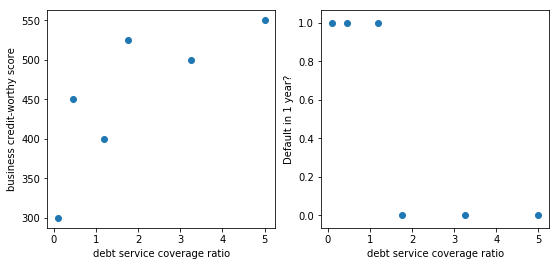

In [235]:
# Create arrays
dscr = np.array([0.1, 0.45, 1.2, 1.75, 3.25, 5])
score = np.array([300.0, 450.0, 400.0, 525.0, 500.0, 550.0])
def_flag = np.array([1, 1, 1, 0, 0, 0])
# Create Dataset
eg_data = pd.DataFrame({"dscr": dscr, "score": score, "def_flag": def_flag})
print(eg_data)
# Plot the simple example
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(dscr, score)
plt.ylabel('business credit-worthy score')
plt.xlabel('debt service coverage ratio')
plt.subplot(122)
plt.scatter(dscr, def_flag)
plt.ylabel('Default in 1 year?')
plt.xlabel('debt service coverage ratio')
plt.show()

## 5.1 XGBoost - One Regression Tree (MSE as loss)

In [238]:
# Prediction at initial step: y = 0.5
# Assume maximum depth is 2, lambda = 0, gamma = 0, learning_rate = 0.3
lambda_ = 0
gamma_ = 0
pred = 0.5
learning_rate = 0.3
# Define a function that can select the best split at each level
def select_split(Xsplits, pred, y, rootscore):
    left_simi_score, right_simi_score, gain= np.zeros(len(Xsplits)), np.zeros(len(Xsplits)), np.zeros(len(Xsplits))
    for i in range(1, len(Xsplits) + 1):
        left_simi_score[i-1] = (sum(y[:i] - pred)) ** 2 /(i + lambda_) 
        right_simi_score[i-1] = (sum(y[i:] - pred)) ** 2 /(len(Xsplits) + 1 - i + lambda_) 
        gain[i-1] = left_simi_score[i-1] + right_simi_score[i-1] - rootscore - gamma_ 
    if np.max(gain) > 0:
        best_split = Xsplits[(gain == np.max(gain)) & (gain > 0)].item()
        simi_score = [left_simi_score[(gain == np.max(gain)) & (gain > 0)].item(), right_simi_score[(gain == np.max(gain)) & (gain > 0)].item()]
    else:
        best_split = simi_score = None
    return best_split, simi_score

# Similarity score with no split
simi_score_root = (sum(score - 0.5)) ** 2 /(len(score) + lambda_)
print(simi_score_root)
# Possible splits at level 1
split_lvl_1 = np.array([(dscr[i] + dscr[i+1])/2 for i in range(0, len(dscr)-1)])
best_split_lvl_1, simi_score_lvl_1 = select_split(split_lvl_1, 0.5, score, simi_score_root)
print("Best first level split: " + str(best_split_lvl_1))
# Possible splits at level 2
split_lvl_2l = split_lvl_1[split_lvl_1 < best_split_lvl_1]
split_lvl_2r = split_lvl_1[split_lvl_1 > best_split_lvl_1]
best_split_lvl_2l, simi_score_lvl_2l = select_split(split_lvl_2l, 0.5, score[dscr < best_split_lvl_1], simi_score_lvl_1[0])
print("Best second level split on the left branch: " + str(best_split_lvl_2l))
best_split_lvl_2r, simi_score_lvl_2r = select_split(split_lvl_2r, 0.5, score[dscr >= best_split_lvl_1], simi_score_lvl_1[1])
print("Best second level split on the right branch: " + str(best_split_lvl_2r))

# Calculate the output value/w_j
def output_value(best_split_lvl_1, best_split_lvl_2l, best_split_lvl_2r, y):
    w_1 = w_2 = w_3 = w_4 = None
    if (best_split_lvl_1 != None) & (best_split_lvl_2l != None) & (best_split_lvl_2r != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_2l] - 0.5)/len(y[dscr < best_split_lvl_2l])
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)] - 0.5) / len(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)])
        w_3 = learning_rate * sum(y[(dscr >= best_split_lvl_1)& (dscr < best_split_lvl_2r)] - 0.5) / len(y[(dscr >= best_split_lvl_1)& (dscr < best_split_lvl_2r)])
        w_4 = learning_rate * sum(y[dscr >= best_split_lvl_2r] - 0.5) / len(y[dscr >= best_split_lvl_2r])
    elif (best_split_lvl_1 != None) & (best_split_lvl_2l != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_2l] - 0.5)/len(score[dscr < best_split_lvl_2l])
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)] - 0.5) / len(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)])
        w_3 = learning_rate * sum(y[(dscr >= best_split_lvl_1)] - 0.5) / len(y[(dscr >= best_split_lvl_1)])
    elif  (best_split_lvl_1 != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_1] - 0.5)/len(y[dscr < best_split_lvl_1])
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_1)] - 0.5) / len(y[(dscr >= best_split_lvl_1)])
    else:
        print("No split!")
    return w_1, w_2, w_3, w_4
w_1, w_2, w_3, w_4 = output_value(best_split_lvl_1, best_split_lvl_2l, best_split_lvl_2r, score)
print("Output values for each leafs are: " + str([w_1, w_2, w_3, w_4]))

1234880.6666666667
Best first level split: 1.475
Best second level split on the left branch: 0.275
Best second level split on the right branch: 4.125
Output values for each leafs are: [89.85, 127.35, 153.6, 164.85]


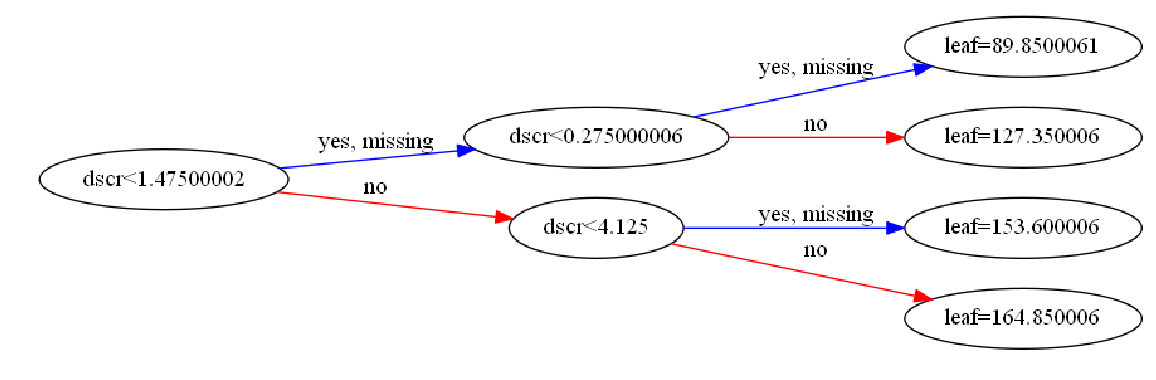

In [246]:
# You can verify the above results from the XGBRegressor!
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.3, max_depth=2, reg_alpha = 0, reg_lambda=0, gamma = 0, base_score = 0.5, n_estimators=1)
xgb_reg.fit(eg_data[["dscr"]], eg_data.iloc[:, 1])
xgb.plot_tree(xgb_reg, num_trees=0, rankdir='LR')
plt.rcParams['figure.figsize'] = [20, 12]
plt.show()

## 5.2 XGBoost - One Classification Tree - <mark> TBA </mark>

In [255]:
# Prediction at initial step: y = 0.5
# Assume maximum depth is 2, lambda = 0, gamma = 0, learning_rate = 0.3
lambda_ = 0
gamma_ = 0
pred = 0.5
learning_rate = 0.3
# Define a function that can select the best split at each level
def select_split_class(Xsplits, pred, y, rootscore):
    left_simi_score, right_simi_score, gain= np.zeros(len(Xsplits)), np.zeros(len(Xsplits)), np.zeros(len(Xsplits))
    for i in range(1, len(Xsplits) + 1):
        left_simi_score[i-1] = (sum(y[:i] - pred)) ** 2 /(i * pred * (1-pred) + lambda_) 
        right_simi_score[i-1] = (sum(y[i:] - pred)) ** 2 /((len(Xsplits) + 1 - i) * pred * (1-pred) + lambda_) 
        gain[i-1] = left_simi_score[i-1] + right_simi_score[i-1] - rootscore - gamma_ 
    if np.max(gain) > 0:
        best_split = Xsplits[(gain == np.max(gain)) & (gain > 0)].item()
        simi_score = [left_simi_score[(gain == np.max(gain)) & (gain > 0)].item(), right_simi_score[(gain == np.max(gain)) & (gain > 0)].item()]
    else:
        best_split = simi_score = None
    return best_split, simi_score

# Similarity score with no split
simi_score_root = (sum(def_flag- 0.5)) ** 2 /(len(def_flag) + lambda_)
print(simi_score_root)
# Possible splits at level 1
split_lvl_1 = np.array([(dscr[i] + dscr[i+1])/2 for i in range(0, len(dscr)-1)])
best_split_lvl_1, simi_score_lvl_1 = select_split_class(split_lvl_1, 0.5, def_flag, simi_score_root)
print("Best first level split: " + str(best_split_lvl_1))
# Possible splits at level 2
split_lvl_2l = split_lvl_1[split_lvl_1 < best_split_lvl_1]
split_lvl_2r = split_lvl_1[split_lvl_1 > best_split_lvl_1]
best_split_lvl_2l, simi_score_lvl_2l = select_split_class(split_lvl_2l, 0.5, def_flag[dscr < best_split_lvl_1], simi_score_lvl_1[0])
print("Best second level split on the left branch: " + str(best_split_lvl_2l))
best_split_lvl_2r, simi_score_lvl_2r = select_split_class(split_lvl_2r, 0.5, def_flag[dscr >= best_split_lvl_1], simi_score_lvl_1[1])
print("Best second level split on the right branch: " + str(best_split_lvl_2r))
# Calculate the output value/w_j
def output_value_class(best_split_lvl_1, best_split_lvl_2l, best_split_lvl_2r, y):
    w_1 = w_2 = w_3 = w_4 = None
    if (best_split_lvl_1 != None) & (best_split_lvl_2l != None) & (best_split_lvl_2r != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_2l] - 0.5)/(len(y[dscr < best_split_lvl_2l]) * pred * (1-pred))
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)] - 0.5) /(len(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)]) * pred * (1-pred))
        w_3 = learning_rate * sum(y[(dscr >= best_split_lvl_1)& (dscr < best_split_lvl_2r)] - 0.5) /(len(y[(dscr >= best_split_lvl_1)& (dscr < best_split_lvl_2r)]) * pred * (1-pred))
        w_4 = learning_rate * sum(y[dscr >= best_split_lvl_2r] - 0.5) / (len(y[dscr >= best_split_lvl_2r]) * pred * (1-pred))
    elif (best_split_lvl_1 != None) & (best_split_lvl_2l != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_2l] - 0.5)/(len(score[dscr < best_split_lvl_2l]) * pred * (1-pred))
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)] - 0.5) / (len(y[(dscr >= best_split_lvl_2l)& (dscr < best_split_lvl_1)]) * pred * (1-pred))
        w_3 = learning_rate * sum(y[(dscr >= best_split_lvl_1)] - 0.5) / (len(y[(dscr >= best_split_lvl_1)]) * pred * (1-pred))
    elif  (best_split_lvl_1 != None):
        w_1 = learning_rate * sum(y[dscr < best_split_lvl_1] - 0.5)/(len(y[dscr < best_split_lvl_1]) * pred * (1-pred))
        w_2 = learning_rate * sum(y[(dscr >= best_split_lvl_1)] - 0.5) / (len(y[(dscr >= best_split_lvl_1)]) * pred * (1-pred))
    else:
        print("No split!")
    if w_1 != None:
        w_1 = 1/ (np.exp(-w_1) + 1)
    if w_2 != None:
        w_2 = 1/ (np.exp(-w_2) + 1)
    if w_3 != None:
        w_3 = 1/ (np.exp(-w_3) + 1)
    if w_4 != None:
        w_4 = 1/ (np.exp(-w_4) + 1)
    return w_1, w_2, w_3, w_4
w_1, w_2, w_3, w_4 = output_value_class(best_split_lvl_1, best_split_lvl_2l, best_split_lvl_2r, def_flag)
print("Output probability for each leafs are: " + str([w_1, w_2, w_3, w_4]))

0.0
Best first level split: 1.475
Best second level split on the left branch: None
Best second level split on the right branch: None
Output probability for each leafs are: [0.6456563062257954, 0.35434369377420455, None, None]


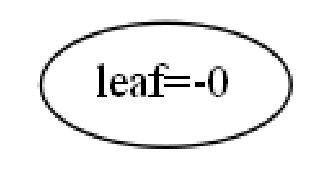

In [257]:
# You can verify the above results from the XGBRegressor???
xgb_class = xgb.XGBClassifier(objective='binary:logitraw', colsample_bytree=1, learning_rate=1, max_depth=2, alpha = 0, reg_lambda=0, gamma = 0, base_score = 0.5, n_estimators=1)
xgb_class.fit(eg_data[["dscr"]], eg_data['def_flag'])
xgb.plot_tree(xgb_class, num_trees=0, rankdir='LR')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## 6. Hyper Parameters and Tuning for XGBoost
### 6.1 Types of Parameters
* **General Parameters**
Which booster (tree or linear model) we want to choose for boosting
* **Booster Parameters**
Parameters related to the booster you choose.
* **Task Parameters**
Parameters decide the learning scenario.
* **Command line parameters**
Parameters that relate to behavior of CLI version of XGBoost.

The following sections will illustrate important and often used parameters under each of the type.
### 6.2 General Parameters
    
| Parameters | Description | Possible values |
| :---|:--- | :--- |
| `booster`(default = `gbtree`) | which booster to use | `gbtree`, `gblinear`, `dart`|
|`verbosity`(default = `1`)| verbosity of printing messages| `0`(silent), `1`(warning), `2`(info), `3`(debug)|
|`nthread`(default to maximum number of threads available if not set)|number of parallel threads used to run XGBoost| - |


### 6.3 Booster Parameters
#### 6.3.1 Tree Booster Parameters
| Parameters | Description | Possible values |
| :--|:-- | :-- |
|`eta`(default = 0.3, or `learning_rate`)|Step size shrinkage used in update to prevents overfitting.|range: $[0, 1]$|
|`gamma`(default = 0, or `min_split_loss`)|Minimum loss reduction required to make a further partition on a leaf node of the tree.|range: $[0,\infty)$|
|`n_estimators`|Number of gradient boosted trees. Equivalent to number of boosting rounds||
|`max_depth`(default=6)|Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.|range: $[0,\infty)$|
|`min_child_weight`(default = 1)|Minimum sum of instance weight (hessian) needed in a child.The larger `min_child_weight` is, the more conservative the algorithm will be|range: $[0,\infty)$|
|`max_delta_step`(default = 0)|Maximum delta step we allow each leaf output to be.|range: $[0,\infty)$|
|`subsample`(default = 1)|Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.|range: $(0, 1]$|
|`colsample_bytree`(default = 1)|subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed|range: $(0, 1]$|
|`sampling_method`(default = `uniform`)|The method to use to sample the training instances.|`uniform`, `gradient_based`|
|`lambda`(default = 1, `reg_lambda`)|L2 regularization term on weights. Increasing this value will make model more conservative.|range: $[0,\infty)$|
|`alpha`(default = 0, `reg_alpha`)|L1 regularization term on weights. Increasing this value will make model more conservative.|-|
|`scale_pos_weight`(default = 1)|Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: `sum(negative instances) / sum(positive instances)`.|-|

#### 6.3.2 Linear Booster Parameters
| Parameters | Description | Possible values |
| :--|:-- | :-- |
|`lambda`(default = 1, `reg_lambda`)|L2 regularization term on weights. Increasing this value will make model more conservative.|range: $[0,\infty)$|
|`alpha`(default = 0, `reg_alpha`)|L1 regularization term on weights. Increasing this value will make model more conservative.|-|

### 6.4 Learning Task Parameters
| Parameters | Description | Possible values |
| :--|:-- | :-- |
|`objective`(default = `reg:squarederror`)|Learning objectives|`reg:squarederror`, `reg:logistic`, `binary:logistic`, `count:poisson`, `survival:cox`, `reg:gamma`|
|`base_score`(default = 0.5)|The initial prediction score of all instances|-|
|`eval_metric`(default according to objective)|Evaluation metrics for validation data|`rmse`, `mae`,`logloss`, `error`, `mlogloss`, `auc`, `poisson-nloglik`, `gamma-nloglik`, `cox-nloglik`|
|`seed`(default = 0)|Random number seed||


### 6.5 Command Line Parameters
<mark> TBA </mark>


## 7. Real Data Example
This section we use German Credit data as an example to use XGboost for classification in python. The following is the data dictionary for this dataset. Some of the variables have been label encoded (i.e. ordinal encoded):

| Variable Name | Description | Values|Type|
| :--|:-- | :-- |:--|
|`Creditability`|Credit-worthiness of a client|1: credit-worthy <br> 0: not credit-worth|Target Variable|
|`Account Balance`|Balance of current account|1: no running account <br> 2: no balance or debit <br> 3: 0 <= ... < 200 DM <br> 4: ... >= 200 DM or checking account for at least 1 year|Ordinal|
|`Duration of Credit (month)`|Duration in months (metric)|-|Numeric|
|`Payment Status of Previous Credit`|Payment of previous credits|0：hesitant payment of previous credits <br> 1:problematic running account / there are further credits running but at other banks <br> 2: no previous credits / paid back all previous credits <br> 3:no problems with current credits at this bank <br> 4:paid back previous credits at this bank|Nominal|
|`Purpose`|Purpose of Credit|0:other <br> 1:new car <br> 2:used car <br> 3:items of furniture <br> 4:radio / television <br> 5:household appliances <br> 6:repair <br> 7:education <br> 8:vacation <br> 9:retraining <br> 10:business|Nominal|
|`Credit Amount`|Amount of credit|-|Numeric|
|`Value Savings/Stocks`|Value of savings or stocks|1:not available / no savings <br> 2: < 100 DM <br> 3: 100 <= ... < 500 - DM <br> 4:500 <= ... < 1000 DM <br> 5: >= 1000 DM|Ordinal|
|`Length of current employment`|Has been employed by current employer for|1: unemployed <br> 2: <= 1 year <br> 3: 1 <= ... < 4 years <br> 4: 4 <= ... < 7 years <br> 5: >= 7 years|Ordinal|
|`Instalment per cent`|Instalment in % of available income|1:>= 35 <br> 2: 25 <= ... < 35 <br> 3:20 <= ... < 25 <br> 4: < 20 |Ordinal|
|`Sex & Marital Status`|Marital Status/Sex|1: male: divorced / living apart <br> 2: male: single <br> 3: male: married / widowed <br> 4: female|Nominal|
|`Guarantors`|Further debtors / Guarantors|1: none <br> 2: Co-Applicant <br> 3: Guarantor|Ordinal|
|`Duration in Current address`|Living in current household for|1: < 1 year <br> 2: 1 <= ... < 4 years <br> 3: 4 <= ... < 7 years <br> 4: >= 7 years|Ordinal|
|`Most valuable available asset`|Most valuable available assets|1: not available / no assets <br> 2: Car / Other <br> 3: Savings contract with a building society / Life insurance <br> 4: Ownership of house or land|Nominal/Ordinal|
|`Age (years)`|Age in years|-|Numeric|
|`Concurrent Credits`|Further running credits|1: at other banks <br> 2: at department store or mail order house <br> 3: no further running credits|Nominal/Ordinal|
|`Type of apartment`|Type of apartment|1: rented flat <br> 2: owner-occupied flat <br> 3: free apartment|Nominal/Ordinal|
|`No of Credits at this Bank`|Number of previous credits at this bank including the running one|1: one <br> 2: two or three <br> 3: four or five <br> 4: six or more|Ordinal|
|`Occupation`|Occupation|1: unemployed / unskilled with no permanent residence <br> 2: unskilled with permanent residence <br> 3: skilled worker / skilled employee / minor civil servant <br> 4: executive / self-employed / higher civil servant|Nominal/Ordinal|
|`No of dependents`|Number of persons entitled to maintenance|1: 0 - 2 <br> 2: 3 and more |Ordinal|
|`Telephone`|Whether he/she has a telephone?|1: no <br> 2: yes|Nominal|
|`Foreign Worker`|Whether he/she is a foreign worker?|1: yes <br> 2:no|Nominal|

## References
1. https://www.shirin-glander.de/2018/11/ml_basics_gbm/#:~:text=Gradient%20Boosting%20Machines%20vs.,XGBoost&text=While%20regular%20gradient%20boosting%20uses,order%20derivative%20as%20an%20approximation.
2. https://xgboost.readthedocs.io/en/latest/index.html